# Perturbation Analysis for Parabolic Partial Differential Equations

In [1]:
import numpy as np
import scipy as sc
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from ipywidgets import *
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.size'] = 15

In [2]:
def cubic_spline(x, y, end=None, k1=0, k2=0, p1=0, p2=0):
    #x: x-coordinates of points
    #y: y-coordinates of points
    #end: Natural, Adjusted, Clamped, Parabolically, NaK
    
    n = len(x)
    A = np.zeros((3*n-3, 3*n-3))
    b = np.zeros(3*n-3)
    
    delta_x=np.diff(x)
       
    #Building the linear system of equations
    
    #1st property
    for i in np.arange(n-1):
        b[i]= y[i+1]-y[i]
        A[i,3*i:3*(i+1)] = [delta_x[i],delta_x[i]**2,delta_x[i]**3]
    #2nd property
    for i in np.arange(n-2):
        A[(n-1)+i,3*i:3*(i+1)+1]=[1, 2*delta_x[i], 3*delta_x[i]**2, -1]
    #3rd property
    for i in np.arange(n-2):
        A[(n-1)+(n-2)+i,3*i:3*(i+1)+2] = [0, 2, 6*delta_x[i], 0, -2]
    
    #Ending conditions (4th property)
    if end =='Natural':
        A[-2,1]= 2
        A[-1,-2] = 2
        A[-1,-1] = 6*delta_x[-1]

    elif end == 'Adjusted':
        A[-2,1]= 2
        A[-1,-2] = 2
        A[-1,-1] = 6*delta_x[-1]
        b[-2:] = [k1,k2]

    elif end == 'Clamped':
        A[-2,0]=1
        A[-1,-3:] = [1,2*delta_x[-1],3*delta_x[-1]**2]
        b[-2:] = [p1,p2]

    elif end == 'Parabolically':
        A[-2,2]=1
        A[-1,-1]=1

    elif end == 'NaK':
        A[-2,2:6]=[6,0,0,-6]
        A[-1,-4:]=[6,0,0,-6]
    
    #Solving the system
    sol = np.linalg.solve(A,b)
    S = {'b':sol[::3],
         'c':sol[1::3],
         'd':sol[2::3],
         'x':x,
         'y':y
        }
    return S

def cubic_spline_eval(xx,S):
    x=S['x']
    y=S['y']
    b=S['b']
    c=S['c']
    d=S['d']
    n=len(x)
    yy=float("nan")
    for i in np.arange(n-1):
        if x[i] <= xx and xx <= x[i+1]:
            yy = y[i]+b[i]*(xx-x[i])+c[i]*(xx-x[i])**2+d[i]*(xx-x[i])**3
    return yy

def cubic_spline_eval2(xx,S):
    x=S['x']
    y=S['y']
    b=S['b']
    c=S['c']
    d=S['d']
    n=len(x)
    yy=np.zeros_like(xx)
    for i in np.arange(n-1):
        jj = np.where(np.logical_and(x[i]<=xx,xx<=x[i+1]))
        yy[jj]=y[i]+b[i]*(xx[jj]-x[i])+c[i]*(xx[jj]-x[i])**2+d[i]*(xx[jj]-x[i])**3
    return yy

In [3]:
def bisect(f, a, b, verb=False, tol=10e-12):
    fa = f(a)
    fb = f(b)
    i = 0
    # Just checking if the sign is not negative => not root  necessarily 
    if np.sign(f(a)*f(b)) >= 0:
        print('f(a)f(b)<0 not satisfied!')
        return None
    
    if verb:
        #Printing the evolution of the computation of the root
        print(' i |     a     |     c     |     b     |     fa    |     fc     |     fb     |   b-a')
        print('----------------------------------------------------------------------------------------')
    
    while(b-a)/2 > tol:
        c = (a+b)/2.
        fc = f(c)
        if verb:
            print('%2d | %.7f | %.7f | %.7f | %.7f | %.7f | %.7f | %.7f' % (i+1, a, c, b, fa, fc, fb, b-a))
        # Did we find the root?
        if fc == 0:
            print('f(c)==0')
            break
        elif np.sign(fa*fc) < 0:
            b = c
            fb = fc
        else:
            a = c
            fa = fc
        i += 1
        
    xc = (a+b)/2.
    return xc

In [4]:
def simpsons(myfun, N, a, b, verbose=False, text="", figname=""):
    f = np.vectorize(myfun) # So we can apply it to arrays without trouble
    x = np.linspace(a, b, N+1) # We want N bins, so N+1 points
    if N%2==1:
        if verbose: print("Simpsons rule only applicable to even number of segments")
        return np.nan
    dx = x[1]-x[0]
    xleft   = x[:-2:2]
    xmiddle = x[1::2]
    xright  = x[2::2]
    int_val = sum((f(xleft)+4*f(xmiddle)+f(xright))*dx/3)
    if verbose:
        xbin, ybin = simpsons_bins(f, xleft, xmiddle, xright)
        plot(f, xbin, ybin, int_val, N, text, figname)
    return int_val

## Introduction

Commonly, exist some phenomena that can be represented as mathematical models, using differential equations. In some cases, simplificationes in the moment of making the model can reduce the difficulty of the representation, but in change, the model could not consider the effect of small factors that are occurring.

Parabolic Partial Differential Equations model different process in the scope of Engineering and Science. One representative Parabolic Partial Differential Equation is the following:
$$
\frac{\partial u(x,t)}{\partial t} = d\,\frac{\partial^2 u(x,t)}{\partial x^2} + c\,\frac{\partial u(x,t)}{\partial x}
$$

Tipically there are processes involved in this equation: advection, difusion and reaction. 

## Method of multiple scales

The method of multiple scales is a general method applicable in a wide range of problems. In this problems there are two processes acting at the same time, each one with its own scale. 
The problem of determinate $u(x,t)$ usually has an approximated value using the approximation:

$$
u(x,t, \varepsilon) \approx u_0(x,t) + \varepsilon \, u_1(x,t)
$$

This expansion works fine with a fixed value of $t$ and $\varepsilon$ near to zero. However, there are problems if $t \geq \mathcal{O}(\varepsilon ^{-1})$. There are two processes acting simultaneously that has its own scales. So, it is necessary to introduce two time variables:

- $\tau = t$ the _fast time_
- $T = \varepsilon t$ the _slow time_

With this variables, the solution proposed by the method has the form:

$$
u(x,t,\varepsilon) \approx u(x,\tau, T, \varepsilon)
$$

In this maner, variations of time must be deteminated in function of the variations of the _fast time_ and _slow time_. In terms of algebra:

$$
\frac{\mathrm{d}}{\mathrm{d}t} = \left( \frac{ \partial }{\partial \tau} \right) + \varepsilon \left( \frac{\partial}{\partial T} \right)
$$

Finally, the approximation for $u(x,t)$ that is asymptotic for $T = \mathcal{O}(1)$ is:

$$
u(x,t,\varepsilon) \approx u_0(x,\tau,T) + \varepsilon\, u_1(x,\tau,T)
$$

The next step is to determinate the functions $u_k$, replacing into the partial differential equation and comparing coefficients of $\varepsilon^k$ as usual.

## A diffusion-advection equation

### Application of the Method of multiple scales

Consider the following problem that shows advection around a periodic domain $0 < \theta < 2\pi$ with some small diffusion. 

\begin{align*}
\frac{\partial u(\theta,t)}{\partial t} + \frac{\partial}{\partial \theta} (\omega(\theta)\,u(\theta,t)) &= \varepsilon\frac{\partial^2u(\theta,t)}{\partial \theta^2}\\
u(\theta,0) &= F(\theta)\\
u(0,t) &= u(2\pi,t)
\end{align*}

where $\omega(\theta)$ is given over $0 \leq \theta \leq 2\pi$, periodic and positive. $F(\theta)$ is a known function and $\varepsilon$ is a tiny value.

 As can be seen there are two process acting at simultaneously: advection on the fast time scale and difusion on the slow scale. According to the method, the next expansion is used:
 
$$
u(\theta,t,\varepsilon) \approx u_0(\theta,\tau,T) + \varepsilon\, u_1(\theta,\tau,T)
$$

Sustituing into the equation and comparing coefficients there are derivated problems to solve.

**First problem**

$
\mathcal{O}(1):
$

$$
\frac{\partial u_0}{\partial \tau} + \frac{\partial}{\partial \theta}(\omega(\theta) \, u_0) = 0
$$

The first problem can be rewrited as:

$$
\frac{1}{\omega} \left( \frac{\partial}{\partial \tau} + \omega \frac{\partial}{\partial \theta}\right) (\omega\, u_0) = 0
$$

This is an advection problem that depends only of the fast time, no slow time are implicated. An observed moving at  a speed $\omega$ will see the quantity $\omega \, u_0$ remain constant. If the value of $\omega(\theta)$ was $\omega(\theta) = \omega$, where $\omega$ is constant, the solution is reduced to $u_0(\theta,\tau,T) = F(\theta-\omega\tau)$, where $F(\theta)$ is the initial value. However, in a general scenario, is necessary to know how much advanced is done after a time $\tau$. Consider the following initial value problem:

\begin{align*}
\frac{\mathrm{d}\theta}{\mathrm{d}t} &= \omega(\theta)\\
\theta(0) &= 0
\end{align*}

Supouse that $\Theta(t)$ is the solution of this problem and, since $\theta$ is a periodic variable, the function $\Theta(t)$ has a period $P$.

The next function solves the Initial Value Problem explained before using the Forward Euler Method. The return of this function is the function $\Theta(t)$ constructed from a cubic spline. Also, the period $P$ of the function $\Theta(t)$ was computed with the reconstructed funcion form cubic spline [2] modulo $2\pi$. A verification of the period was employed using the Bisection method [1]. In order to determinate a value $s$ such that $\Theta(s) = \hat{\theta}$, since $\Theta(0) = 0$. Let $T(s)$ be the function:

$$
T(s) = \Theta(s) - \hat{\theta}
$$

So, finding a root for $T(s)$, is possible to verify when the displacement reaches multiplies of $2\pi$ and later, obtain the period $P$.

In [5]:
def solve_IVP(w,t_max=10,show_plot=False,delta=1):
    #using Explicit Euler Method to estimate de IVP
    t = np.linspace(0,t_max,50)
    tt = np.linspace(0,t_max,1000)
    h = t[1] - t[0]
    theta = np.zeros(t.shape)
    theta[0] = 0
    for i in range(t.shape[0]-1):
        theta[i+1] = theta[i] + h*w(theta[i],delta)
        
    #compute cubic splines for estimate the funtion
    spl = cubic_spline(t,theta,end="Natural")
    
    if show_plot:
        plt.figure(figsize=(8,5))
        #plot points of the numerical solution for theta
        plt.plot(t,theta,"ro",label=r"$\Theta(t)$")    
        #plot spline function using the previous points
        plt.plot(tt,cubic_spline_eval2(tt,spl),"-g",label=r"Splines for $\Theta(t)$")
        
        #get the period of the function
        #th = [2*np.pi,4*np.pi,6*np.pi]
        th = [2*np.pi]
        list_s = []   

        for i in th:
            f = lambda x: cubic_spline_eval(x,spl) - i
            #obtain the time s where theta(s) = 2pi, 4pi and 6pi
            s = bisect(f,0,t_max,verb=False)
            #plot a vertical line
            plt.axvline(x=s, color='k', linestyle='--')
            list_s.append(s)

        #plot the points where theta(s) = 2pi, 4pi and 6pi
        plt.plot(list_s,th,"Db")   
        
        #plot the spline functions mod 2pi to verify the period
        plt.plot(tt,(cubic_spline_eval2(tt,spl)%(2*np.pi)),"-b",label=r"$\Theta(t)$ mod $2\pi$")
        #other configurations of the plot
        plt.grid(True)
        plt.legend(loc="best")
        plt.xlabel(r"$t$")
        plt.ylabel(r"$\Theta(t)$")
        plt.title("Period P = "+str(list_s[0])+" [s]")
        #save image in pdf
        plt.savefig("Theta.pdf")
        plt.show()
        
    Theta = lambda x: cubic_spline_eval(x,spl)
    
    return Theta

In [6]:
def plot_Theta(w,delta):
    t_max = 25
    Theta = solve_IVP(w,t_max,False,delta)
    vTheta = np.vectorize(Theta)
    t = np.linspace(0,t_max,50)
    tt = np.linspace(0,t_max,1000)
    plt.figure(figsize=(8,5))
    #plot points of the numerical solution for theta
    plt.plot(t,vTheta(t),"ro",label=r"$\Theta(t)$")    
    #plot spline function using the previous points
    plt.plot(tt,vTheta(tt),"-g",label=r"Splines for $\Theta(t)$")

    #get the period of the function 
    f = lambda x: Theta(x) - 2*np.pi
    #obtain the time s where theta(s) = 2pi
    s = bisect(f,0,t_max,verb=False)
    #plot a vertical line
    plt.axvline(x=s, color='k', linestyle='--')

    #plot the points where theta(s) = 2pi, 4pi and 6pi
    plt.plot(s,2*np.pi,"Db")   

    #plot the spline functions mod 2pi to verify the period
    plt.plot(tt,vTheta(tt)%(2*np.pi),"-b",label=r"$\Theta(t)$ mod $2\pi$")
    #other configurations of the plot
    plt.grid(True)
    plt.legend(loc="best")
    plt.xlabel(r"$t$")
    plt.ylabel(r"$\Theta(t)$")
    plt.title("Period P = "+str(s)+" [s]")
    #save image in pdf
    #plt.savefig("Theta.pdf")
    plt.show()

In order to solve the first problem, a change of variable to Lagrangian coordinates $s$ and $\tau$ will be done. Let:

$$
\theta(s,\tau) = \Theta(\tau - s)
$$

Where $s$ is the **time delay** since $\theta$ was zero. With that, the coordinate system consisting of one spatial variable $\theta$ and temporal variables $\tau$ and $T$, changes into temporal variables $\tau$, $T$ and $s$.

Using the chain rule to recast the differential equation, the following equalities are valid:
    
\begin{align*}
\left(\frac{\partial}{\partial \tau} \right)_s &= \left( \frac{\partial}{\partial \tau}  \right)_\theta + \omega \left( \frac{\partial}{\partial \theta} \right)_{\tau}\\
\left( \frac{\partial}{\partial \theta} \right)_\tau &= -\frac{1}{\omega} \left( \frac{\partial}{\partial s} \right)_{\tau}
\end{align*}
    

Replacing into the equation, the problem is reduced to:

$$
\left(\frac{\partial}{\partial \tau} \right)_s (\omega\,u_0) = 0
$$

Which has constant solution for variable $\tau$ in this coordinate system. The value of $u_0$ can be determinated defining a function $A_0$, which depends of $s$ and $T$ and the speed $\omega$:

$$
u_0(\theta, \tau, T) = \frac{A_0(s,T)}{\omega(\theta)}
$$

This shows that an observed moving at a speed $\omega(\theta)$ will see the quantity $\omega\,u_0$ remain constant. But, this constant is allowed to modify its value in the slow scale $T$. The initial value of this _constant_ is given by the initial condition of the problem:

$$
A_0(s,0) = F(\Theta(-s))\omega(\Theta(-s))
$$


In order to deteminate $A_0$ the second problem must be aborded.

**Second Problem**

$
\mathcal{O}(\varepsilon):
$

$$
\frac{\partial u_0}{\partial T}+ \frac{\partial u_1}{\partial \tau} + \frac{\partial}{\partial \theta} (\omega(\theta) \, u_1) = \frac{\partial^2 u_0}{\partial \theta^2}
$$

Replacing the partially determined $u_0$, the problem becomes:

$$
\frac{1}{\omega} \frac{\partial A_0}{\partial T} + \frac{1}{\omega} \left(\frac{\partial}{\partial \tau}\right)_s (\omega\,u_1) = \frac{1}{\omega} \left( \frac{\partial}{\partial s} \right)_{\tau}\frac{1}{\omega} \left( \frac{\partial}{\partial s} \right)_{\tau} \frac{A_0}{\omega}
$$

with $\omega = \omega(\Theta(\tau-s))$ a $P$-periodic function of $s$ and $\tau$. Thus:

$$
\frac{\partial A_0}{\partial T} + \left(\frac{\partial}{\partial \tau}\right)_s (\omega\,u_1) = \frac{1}{\omega^2} \frac{\partial^2A_0}{\partial s^2}+ \frac{3}{2} \frac{\partial}{\partial s}\left( \frac{1}{\omega^2} \right) \frac{\partial A_0}{\partial s}+\frac{1}{2}\frac{\partial^2}{\partial s^2} \left( \frac{1}{\omega^2}\right) A_0
$$

The right side of the equation has non zero average. In order to mantain the asymptoticness of the expansion of $f$ in $T = \mathcal{O}(1)$, the quantity $\omega \,u_1$ has to be bounded as $\tau$ increases. Thus, the average with respect to $\tau$ of the right hand side must be removed by setting equal to $\displaystyle\frac{\partial A_0}{\partial T}$. The second and third terms of the right side has zero average because they are derivatives with respect to $s$ of functions of $\omega$ and so derivatives with respect to $\tau$. The next equalty must be satisfied:

$$
\frac{\partial A_0}{\partial T} = \frac{1}{P} \int_{0}^{P} \frac{1}{\omega^2(\Theta(\tau-s))} \mathrm{d}\tau \frac{\partial^2A_0}{\partial s^2}
$$

The previous equation corresponds to a Parabolic PDE with diffusion coeficient equals to the average value of $1/\omega^2$, that can be solved numerically in order to detemine $A_0$.

**Generically**, the problem can be solve using a numerical aproximation for the integral and using the value obtained in the PDE:

$$
\begin{aligned}
\frac{1}{P}\int_{0}^{P} \frac{1}{\omega^2(\Theta(\tau-s))} \approx \frac{1}{P} \sum_{i=1}^{K} w_i \frac{1}{\omega^2(\Theta(\tau_i-s))} = c(s)
\end{aligned}
$$

Where $w_i$ is the weigh used in the sum of $K$ terms and depends of the numerical method used to estimate the value of the integral. Also, this value depends of temporal variable $s$. So, let $c(s)$ the value of the integral divided by the period $P$ using a numerical method.

Now, considering the PDE with the estimation of the integral as the following equation:

$$
\begin{aligned}
\frac{\partial A_0}{\partial T} &= c(s) \frac{\partial^2A_0}{\partial s^2}
\end{aligned}
$$

Using an implicit finite difference approach for the variable $T$ and central difference for the variable $s$:

The equations to be solved for $j = 1, 2, \ldots N$ are:

$$
- \sigma_j\,a_{j-1,n+1} + (1+2\,\sigma_j)\,a_{j,n+1}-\sigma_j\,a_{j+1,n} = a_{j,n}
$$

where $\sigma_j = \displaystyle\frac{c(s_j)\Delta T}{\Delta s^2}$. And $s$ is a periodic variable.

Also, is possible use a 


The next code implements the solution of this PDE, according to the previous explanation

In [7]:
def solve_a0(w,F,eps=0.01,t_max=10,points_s=50,points_T=500,delta=1,num=1):
    Theta = solve_IVP(w,25,False,delta)
    th1 = lambda x: Theta(x) - 2*np.pi
    #t1 is the period P of Theta(t)
    t1 = bisect(th1,0,25,verb=False)
    #t2 is two periods of Theta(t)
    t2 = 2*t1

    #take equidistant values in the s axis
    s = np.linspace(0,t1,points_s)
    delta_s = t1/(points_s-1)
    
    #tau is taked between P and 2*P for correctly evaluation of Theta(t)
    tau = np.linspace(t1,t2,points_s)
    #vector c for save the values of c_j
    c = np.zeros_like(s)
    
    for j in range(s.shape[0]):
        #compute the numerical quadrature of myfun with variable s
        myfun = lambda x: 1/((w(Theta(x-s[j]),delta))**2)
        #using simpsons rule, number points_s must be EVEN
        val = simpsons(myfun, points_s, t1, t2)/t1
        #saving the value of c_j
        c[j] = val
    
    #computing delta_T
    delta_T = (t_max)/(points_T-1)
    #compute the values of sigma_j
    sigma = (delta_T/(delta_s**0.5))*c
    
    #compute matrix
    A = np.zeros((points_s,points_s))
    for i in range(points_s):
        A[i][i] = 1+2*sigma[i]
        if i < points_s-1:
            A[i+1][i] = -sigma[i]
        if i > 0:
            A[i-1][i] = -sigma[i]
    A[-1][0] = -sigma[0]
    A[0][-1] = -sigma[-1]
    
    
    sols = np.zeros((points_s,points_T+1))
    for i in range(points_s):
        sols[i,0] = F(Theta(t1-s[i]),num)*w(Theta(t1-s[i]),delta)
        
    for i in range(1,points_T+1):
        sols[:,i] = np.linalg.solve(A,sols[:,i-1])    
    return s,sols,delta_T

In [8]:
def print_simulation_a0(i,eps,delta=1,num=1):
    s,a0,d_T = solve_a0(w,F,eps,10,50,500,delta,num)
    plt.figure(figsize=(10,5))
    plt.plot(s,a0[:,i],"ro")
    plt.xlabel("$s$")
    plt.ylabel("$A_0(s,T)$")
    plt.title(r"$A_0(s,T)$ for $T = "+str(d_T*i)+"$")#"$, $t="+str(d_T*i/eps)+"$")
    plt.ylim(-3,3)
    plt.grid(True)
    plt.show()

Finally, in order to obtain $u_0(\theta,\tau,T)$, is necessary to determinate which $s$ corresponds to a value of $\hat{\theta}$ given. The value of $u_0(\hat{\theta},\tau,T)$ is given by:

$$
u_0(\hat{\theta},\tau,T) = \frac{A_0(s,T)}{\omega(\hat{\theta})}
$$

Let $R(\alpha)$ be the function:

$$
R(\alpha) = \Theta(\alpha) - \hat{\theta}
$$

So, finding a root for $R(\alpha)$, the value of $\alpha$ such $\Theta(\alpha) = \hat{\theta}$ is found. In this case, is necesary go from lagrangian coordinate system to a traditional coordinate system space-time and $\alpha$ is interpretated as $\tau-s$ of the lagrangian coordinates. So, $s$ is creared from the original definition of lagrangian coordinates:

$$
\begin{aligned}
\Theta(\tau-s) &= \Theta(\alpha) = \hat{\theta}\\
& \Rightarrow \tau-s = \alpha\\
& \Rightarrow s = \tau - \alpha
\end{aligned}
$$

Finally, with this value of $s$ is possible to come back to traditional coordinate system to interpretate and compare results.

The next code implements the calculation of values for $u_0$ taking equdistant points in the $\theta$ axis from $0$ to $2\pi$. The bisection method [1] was used for obtain the zeros of $R(\alpha)$ when was needed. 

In [9]:
def get_u0(w,F,i,eps=0.01,t_max=10,points_th=50,points_T=500,delta=1,num=1):
    Theta = solve_IVP(w,25,False,delta)
    th1 = lambda x: Theta(x) - 2*np.pi
    #get period of the function
    period = bisect(th1,0,25,verb=False)
    
    #points to using in the s axis
    points_s = 50
    
    #computing A0(s,T)
    s, a0, delta_T = solve_a0(w,F,eps,t_max,points_s,points_T,delta,num)
    
    #obtain points between 0 and 2pi
    th = np.linspace(0,2*np.pi,points_th)
    
    #generate structure to save values of u0
    u_0 = np.zeros_like(th)    
    
    #compute cubic spline for a0 in T = i*delta_T
    spl = cubic_spline(s,a0[:,i],end="Natural")
    a_0 = lambda x: cubic_spline_eval(x,spl)

    for j in range(1,th.shape[0]):
        fun = lambda x: Theta(x)-th[j]
        alpha = bisect(fun,0,2*period,verb=False)
        s2 = (i*delta_T-alpha)%period
        u_0[j] = a_0(s2)/w(th[j],delta)
    u_0[0] = u_0[-1]
    return th,u_0,delta_T

In [10]:
def print_simulation_u0(i,eps,delta=1,num=1):
    th,u0,d_T = get_u0(w,F,i,eps,10,50,500,delta,num)
    plt.figure(figsize=(10,5))
    plt.plot(th,u0,"gD")
    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$u_0(\theta,\tau,T)$")
    plt.title(r"$u_0(\theta,\tau,T)$ for $T = "+str(d_T*i)+"$")
    plt.ylim(-3,3)
    plt.grid(True)
    plt.show()

### Using Finite Difference Method

Next, the problem is solved numerically with finite differences with an implicit method. Consider the problem in the form:

$$
\frac{\partial u(\theta,t)}{\partial t} + \frac{\mathrm{d}\omega(\theta_i)}{\mathrm{d} \theta} u(\theta,t) + \frac{\partial u(\theta,t)}{\partial \theta} \omega(\theta) = \varepsilon \frac{\partial^2 u(\theta,t)}{\partial \theta^2}
$$

The formulas of the **implicit** finite differences will be **backward in time** and **central in space** for the first derivative (in order to mantain the spatial derivative with a second order aproximation). Let $u_{i,n} \approx u(\theta_i,t_n)$, where $\theta_i$ and $t_n$ are $N_{\theta}$ and $N_{t}$ equidistant points in the spatial and temporal axes.


$$
\begin{aligned}
\frac{\partial u(\theta,t)}{\partial t} &= \frac{u_{i,n}-u_{i,n-1}}{\Delta t} + \mathcal{O}(\Delta t)\\
\frac{\partial u(\theta,t)}{\partial \theta} &= \frac{u_{i+1,n}-u_{i-1,n}}{2\,\Delta \theta} + \mathcal{O}(\Delta \theta^2)\\
\frac{\partial^2 u(\theta,t)}{\partial \theta^2} &= \frac{u_{i-1,n}-2\,u_{i,n}+u_{i+1,n}}{\Delta \theta^2} + \mathcal{O}(\Delta \theta^2)\\
\end{aligned}
$$

Replacing into the PDE, there are a system of equation to be solved for unkowns in different values of time where the equations are given by:

$$
\left( \frac{\omega(\theta_i)\,\Delta t}{2\Delta \theta}-\frac{\varepsilon\, \Delta t}{\Delta \theta^2} \right)\,u_{i-1,n+1}+ \left( 1+\frac{\mathrm{d}\omega(\theta_i)}{\mathrm{d} \theta}\Delta t + 2\frac{\varepsilon\, \Delta t}{\Delta \theta^2} \right)\,u_{i,n+1} + \left(- \frac{\omega(\theta_i)\,\Delta t}{2\Delta \theta}-\frac{\varepsilon\, \Delta t}{\Delta \theta^2} \right)\, u_{i+1,n+1} = u_{i,n}
$$

for $0 \leq i<N_{\theta}$ and $n>0$. For a better visualization, let be:

$$
\begin{aligned}
\alpha &= \frac{\varepsilon\,\Delta t}{\Delta \theta^2}\\
\beta_i &= \frac{\omega(\theta_i)\,\Delta t}{\Delta \theta}\\
\gamma_i &= \omega'(\theta_i)\,\Delta t
\end{aligned}
$$

So, the previous equation can be written as:

$$
\left( \frac{1}{2}-\frac{\varepsilon\, \Delta t}{\Delta \theta^2} \right)\,u_{i-1,n+1}+ \left( 1+\frac{\mathrm{d}\omega(\theta_i)}{\mathrm{d} \theta}\Delta t + 2\frac{\varepsilon\, \Delta t}{\Delta \theta^2} \right)\,u_{i,n+1} + \left(- \frac{\omega(\theta_i)\,\Delta t}{2\Delta \theta}-\frac{\varepsilon\, \Delta t}{\Delta \theta^2} \right)\, u_{i+1,n+1} = u_{i,n}
$$

So, the previous equation can be written as:

$$
\left( \frac{\beta_i}{2}- \alpha \right)\,u_{i-1,n+1}+ \left( 1+ \gamma_i + 2 \alpha \right)\,u_{i,n+1} + \left(-  \frac{\beta_i}{2} - \alpha \right)\, u_{i+1,n+1} = u_{i,n}
$$

for $0 \leq i<N_{\theta}$ and $n>0$.

An **explicit** finite difference can be employed using the forward difference for the temporal variable and mantaining the previous differences for the spatial variable:

$$
\begin{aligned}
\frac{\partial u(\theta,t)}{\partial t} &= \frac{u_{i,n+1}-u_{i,n}}{\Delta t} + \mathcal{O}(\Delta t)\\
\frac{\partial u(\theta,t)}{\partial \theta} &= \frac{u_{i+1,n}-u_{i-1,n}}{2\,\Delta \theta} + \mathcal{O}(\Delta \theta^2)\\
\frac{\partial^2 u(\theta,t)}{\partial \theta^2} &= \frac{u_{i-1,n}-2\,u_{i,n}+u_{i+1,n}}{\Delta \theta^2} + \mathcal{O}(\Delta \theta^2)\\
\end{aligned}
$$


So, the iterative step to be calculated will be:
$$
u_{i,n+1} = \left( \frac{\beta_i}{2}+ \alpha \right)\,u_{i-1,n}+ \left( 1- \gamma_i - 2 \alpha \right)\,u_{i,n} + \left(-  \frac{\beta_i}{2} + \alpha \right)\, u_{i+1,n}
$$

for $0 \leq i<N_{\theta}$ and $n>0$.

The following code implements finite difference method for this problem.

In [42]:
def fd_method(w,wp,F,N,M,t_max,eps,delta=1,num=1,method="Implicit"):
    Theta = np.linspace(0,2*np.pi,N)
    dt = t_max/(M-1)
    
    dth = Theta[1]-Theta[0]

    A = np.zeros((N-1,N-1))
    b = np.zeros((N,M))

    b[:-1,0] = F(Theta[:-1],num)
    b[-1] = b[0]
    
    #defining some "constants" for matrix generation
    alpha = ((eps*dt)/(dth**2))*np.ones(N)
    beta = (dt/dth)*w(Theta,delta)
    gamma = dt*wp(Theta)  
    
    if method=="Implicit":
        for i in range(N-1):
            A[i,i] = 1+2*alpha[i]+gamma[i]
            A[i,i-1] = -alpha[i]-0.5*beta[i]
            if i<N-2:
                A[i,i+1] = -alpha[i]+0.5*beta[i]
            else:
                A[i,0] = -alpha[i]+0.5*beta[i]
        print(A)
        for j in range(M-1):
            b[:-1,j+1] = np.linalg.solve(A,b[:-1,j])
            b[-1,:] = b[0,:]
    elif method=="Explicit":
        for i in range(N-1):
            A[i,i] = 1-gamma[i]-2*alpha[i]
            A[i,i-1] = 0.5*beta[i]+alpha[i]

            if i<N-2:
                A[i,i+1] = -0.5*beta[i]+alpha[i]
            else:
                A[i,0] = -0.5*beta[i]+alpha[i]
        print(A)
        for j in range(M-1):
            b[:-1,j+1] = np.dot(A,b[:-1,j])
            b[-1,:] = b[0,:]
        
    return b

### Using FFT

The Fast Fourier Transform will be used to determine the spatial derivative of $u(\theta,t)$ knowing the value of $u$ in the initial time, i.e. since the value of $u(\theta,t=0)$ is known, the value of $\displaystyle\frac{\partial^n u(\theta, t=0)}{\partial \theta^n}$ can be determinated. Besides, the spatial variable is periodic with period equal to $2\pi$. Later, using a forward approach for the temporal variable, solutions of $u(\theta,t)$ will be obtained.

Consider the problem in the form:

$$
\frac{\partial u(\theta,t)}{\partial t} + \frac{\mathrm{d} \omega(\theta)}{\mathrm{d} \theta} u(\theta,t) + \frac{\partial u(\theta,t)}{\partial \theta} \omega(\theta) = \varepsilon \frac{\partial^2 u(\theta,t)}{\partial \theta^2}
$$

Let be $w^{(k)}_{j,n}$ the value obtained using FFT for the derivative of $k$ order for $u(\theta,t)$ evaluated in $\theta_j$ for the time $t_n$. Let be $v_{j,n}$ the aproximation of $u(\theta,t)$ evaluated in $\theta_j$ for the time $t_n$. Put all the previous definitions together, the problem is reduced to an iterative method that calculates the next time step using the information of the values of $u(\theta_j,t_n)$, the first derivative of $u(\theta_j,t_n)$ and the second derivative of $u(\theta_j,t_n)$ for the actual time. Consider that $\theta_i$ and $t_n$ are $N_{\theta}$ and $N_{t}$ equidistant points in the spatial and temporal axes.

The iterative step to be used in this case is:

$$
v_{j,n+1} = \varepsilon\,\Delta t\,w_{j,n}^{(2)} - \omega(\theta_j)\,\Delta t\,w_{j,n}^{(1)}+(1-\omega'(\theta_j)\,\Delta t)v_{j,n}
$$
for $0 \leq j<N_{\theta}$ and $n>0$.


The next code implements the spectral derivative using FFT in order to obtain the derivative of $\nu$ order of a function $v$ valid for the spatial interval $[0,2\pi]$. The code was extracted from [3].

In [12]:
def spectralDerivativeByFFT(v,nu=1):
    if not np.all(np.isreal(v)):
        raise ValueError('The input vector must be real')
    N=v.shape[0]
    K=np.fft.fftfreq(N)*N
    iK=(1j*K)**nu
    v_hat=np.fft.fft(v)
    w_hat=iK*v_hat
    if np.mod(nu,2)!=0:
        w_hat[int(N/2)]=0
    return np.real(np.fft.ifft(w_hat))

The next code implements the iterative step in order to solve this kind of problem.

In [13]:
def fft_method(w,wp,F,N,M,t_max,eps,delta=1,num=1):
    Theta = np.linspace(0,2*np.pi,N)
    #T = np.linspace(0,2,M)
    #dt = T[1]-T[0]
    dt = t_max/(M-1)
        
    #defining a matrix to save all the values of the function in all the time steps
    v = np.zeros((N,M))
    #setting values for the initial time
    v[:,0] = F(Theta,num)
    
    w1 = np.zeros(N)
    w2 = np.zeros(N)
    
    #iterative step
    for n in range(M-1):
        #calculate the first derivative with FFT
        w1[1:] = spectralDerivativeByFFT(v[1:,n],1)
        w1[0] = w1[-1]
        #calculate the second derivative with FFT
        w2[1:] = spectralDerivativeByFFT(v[1:,n],2)
        w2[0] = w2[-1]
              
        #get the values of the function in the next time
        v[:,n+1] = eps*dt*w2 - dt*w(Theta,delta)*w1+(np.ones(N)-dt*wp(Theta))*v[:,n]
    return v

### Numerical Examples

For Numerical Examples, three different functions associated to the initial values will be used. These are:

$$
\begin{aligned}
F_1(\theta) &= 2\,\sin{(\theta)}\\
F_2(\theta) &= 2\,\exp{(-(\theta-\pi)^2)}\\
F_3(\theta) &= 2\,\sin^2{(0.5\,\theta)}\\
\end{aligned}
$$


In [14]:
def F(theta,num=1):
    if num == 1:
        return 2*np.sin(theta)
    elif num==2:
        return 2*np.exp(-(theta-np.pi)**2)
    elif num==3:
        return 2*np.sin(0.5*theta)**2
    return theta*0

According to all the theoretical part explained before, two numerical examples will be tested for the diffusion and advection equation.

Again, consider the following problem that shows advection around a periodic domain $0 < \theta < 2\pi$ with some small diffusion. 

\begin{align*}
\frac{\partial u(\theta,t)}{\partial t} + \frac{\partial}{\partial \theta} (\omega(\theta)\,u(\theta,t)) &= \varepsilon\frac{\partial^2u(\theta,t)}{\partial \theta^2}\\
u(\theta,0) &= F(\theta)\\
u(0,t) &= u(2\pi,t)
\end{align*}

where $\omega(\theta)$ is given over $0 \leq \theta \leq 2\pi$, periodic and positive. $F(\theta)$ is a known function and $\varepsilon$ is a tiny value.

**Numerical Example 1**
The first numerical example considers a constant value $\delta$ for the speed $\omega$. Let be:
\begin{align}
\omega(\theta) &= \delta\\
\omega'(\theta) &= 0\\
\end{align}

In [15]:
def w(theta, delta=1):
    return delta*theta**0 
def wp(theta):
    return theta*0

In [16]:
def plot_functions(w,wp,F,delta=1,num=1):
    th = np.linspace(0,4*np.pi,200)
    thh = np.linspace(0,2*np.pi,100)
        
    plt.figure(figsize=(18,5))

    
    label_fun = "0"
    if num==1:
        label_fun=r"2\,\sin{(\theta)}"
    elif num==2:
        label_fun=r"2\,\exp(-(\theta-\pi)^2)"
    elif num==3:
        label_fun=r"2\,\sin(0.5\,\theta)^2"
    
    plt.subplot(121)
    plt.plot(th,w(th,delta),"-r",label=r"$w(\theta) = "+str(delta)+"$")
    plt.plot(th,wp(th),"-b",label=r"$w'(\theta) = 0$")
    plt.xlim(-1,12)
    plt.ylim(-4,4)
    plt.axvline(x=0, color='k', linestyle='--')
    plt.axvline(x=2*np.pi, color='k', linestyle='--')
    plt.grid(True)
    plt.xlabel(r"$\theta$")
    plt.legend(loc="best")
    
    plt.subplot(122)
    plt.plot(thh,F(thh,num),"-g",label = r"$F(\theta) = "+label_fun+"$")
    plt.xlim(-1,7)
    plt.ylim(-4,4)
    plt.axvline(x=0, color='k', linestyle='--')
    plt.axvline(x=2*np.pi, color='k', linestyle='--')
    plt.grid(True)
    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$F(\theta)$")
    plt.legend(loc="best")
    plt.show()

In [17]:
delta_widget = FloatSlider(min=0.4,max=2.0, step=0.1, value=1.0)
fun_widget = Dropdown(options=[1,2,3],
                      value=1, description='Function F')
interact(plot_functions,w=fixed(w),wp=fixed(wp),F=fixed(F),delta=delta_widget,num=fun_widget)

<function __main__.plot_functions>

As can be seen previously, the function $\omega(\theta)$ is a positive and periodic function around the interval $[0,2\pi]$. The derivative of a constant function is zero. The function $F(\theta)$ is shown between the same interval. 

The first approach for this example consists in determinate numerically the solution of the partial differential equation using Finite Differences (Explicit and Implicit) and Fast Fourier Transform.

In [44]:
def simulation(w,wp,F,i,N,M,t_max,eps,fd_mode,delta,num): 
    
    #spatial axis
    Theta = np.linspace(0,2*np.pi,N)
    #temporal axis
    T = np.linspace(0,t_max,M)
    
    y1 = fft_method(w,wp,F,N,M,t_max,eps,delta,num)
    y2 = np.zeros_like(y1)
    label_fd = "No mode selected for FD"
    if fd_mode == "Implicit":
        y2 = fd_method(w,wp,F,N,M,t_max,eps,delta,num)
        label_fd = "Implicit Finite Difference"
    elif fd_mode == "Explicit":
        y2 = fd_method(w,wp,F,N,M,t_max,eps,delta,num,"Explicit")
        label_fd = "Explicit Finite Difference"
        
    a1 = np.zeros(i+1)
    a2 = np.zeros(i+1)
    
    for k in range(i+1):
        a1[k] = max(abs(y1[:,k]))
        a2[k] = max(abs(y2[:,k]))
          
    plt.figure(figsize=(17,13))

    plt.subplot(2, 2, 1)
    plt.title("Simulation at t = "+str(T[i])+" [s]")
    plt.plot(Theta[:],y1[:,i],"-yo", label="Fast Fourier Transform")
    plt.ylim(-5,6)
    plt.grid(True)
    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$u(\theta,t)$")
    plt.legend(loc="best")
    
    plt.subplot(2, 2, 2)
    plt.title("Simulation at t = "+str(T[i])+" [s]")
    plt.plot(Theta[:],y2[:,i],"-bo", label=label_fd)
    plt.ylim(-5,6)
    plt.grid(True)
    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$u(\theta,t)$")
    plt.legend(loc="best")
    
    plt.subplot(2, 2, 3)
    plt.title("Max Absolute Value")
    plt.plot(T[:i+1],a1,"-yo", label="Fast Fourier Transform")
    plt.xlim(-0.1*t_max,1.1*t_max)
    plt.grid(True)
    plt.xlabel(r"$t$")
    plt.ylabel(r"$u(\theta,t)$")
    plt.legend(loc="best")
    
    plt.subplot(2, 2, 4)
    plt.title("Max Absolute Value")
    plt.plot(T[:i+1],a2,"-bo", label=label_fd)
    plt.xlim(-0.1*t_max,1.1*t_max)
    plt.grid(True)
    plt.xlabel(r"$t$")
    plt.ylabel(r"$u(\theta,t)$")
    plt.legend(loc="best")
    
    plt.show()

The numerical simulation can be observed on a interactive way changing some parameters:
* $i$: solution of the equation at time $t_i = i\,\Delta t$. Initially $i = 0$.
* $N$: number of points to be evaluated in the $\theta$ axis. Initially $N = 50$.
* $M$: number of intervals of time to be displayed. Initially $M = 80$.

Aditionally, various values of $\varepsilon$ will be used.

In [45]:
i_widget = IntSlider(min=0, max=79, value=0)
N_widget = IntSlider(min=2, max=200, value=50)
M_widget = IntSlider(min=2, max=400, value=80)
eps_widget = Dropdown(options=[100.,10.,2.,1.,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,
                               1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14,1e-15,1e-16,1e-17,0.],
                      value=0, description='eps')
delta_widget = FloatSlider(min=0.1,max=2.0, step=0.1, value=1.0)
fun_widget = Dropdown(options=[1,2,3],
                      value=1, description='Function F')
fd_widget = Dropdown(options =  ["Explicit", "Implicit"], value="Implicit", description = "FD Mode")
time_widget = IntSlider(min=1,max=10,step=1,value=1,description="Max Time")
def update_i_values(*args):
    i_widget.max = M_widget.value-1
M_widget.observe(update_i_values, 'value')

interact(simulation,
         w=fixed(w),
         wp=fixed(wp),
         F=fixed(F),
         i=i_widget,
         N=N_widget,
         M=M_widget,
         eps=eps_widget,
         t_max = time_widget,
         fd_mode=fd_widget,
         delta=delta_widget,
         num=fun_widget)

<function __main__.simulation>

The first case $\varepsilon = 0$ is simply an advection equation without diffusion. Since the speed $\omega$ is constant the solution, tipically a wave is moving at this constant rate. Is expected that the maximum absolute value of the solution observed be the same in all the time elapsed.
- The FFT has stability problems when $N$ is much greater than $M$ (apparently with a quotient $N/M$ greater to 1 and nearer to 2). Also, when the value of $M$ is tiny the simulation has stability problems more prematurely. In cases where there are no stability issues, the maximum absolute value of the solution is increasing slightly. When the value of $M$ is bigger, i.e., the time between two neighbor points is shorter, the increment of the maximun value obtained is lower that with a $M$ small. This factor maybe is associated with the numerical error of the method.
- The Implicit FD does not have problems of stability. It can be observed that the maximum absolute value of the solutions is decresing in time slightly, and also, with bigger values of $M$ the change in this decrease is lower that the same effect with a small $M$. Again, this difference between the expected behavior and the numerical results can be interpretated as numerical error asociated.
- The Explicit FD does not have problems of stability with in this case and its behaviour is better to comparing with FFT. The maximum value is increasing int time such as FFT. Also, with as greater is the value of $M$, the total increment of the maximum value in time $t=10$ is lower.

Cases when $\varepsilon > 0$ are examples of a advection-diffusion equation when the solution is disipated around the axis. When the coeficient is greater, the disipation of the values is faster. The advection process, barely can be seen. The problem can be seen as the oposite as the original problem with a slow difusion, where now the advection is the slow process compared to the diffusion and if the coeficient of difusion is a big value, then the solution is practicaly a constant solution (explained for a really fast difusion, without considering what was the initial distribution of the function).
- Again, the FFT has stability problems related to the quotient $N/M$ in the same way that the previous case. However, in this cases there is an aditional effect of the $\varepsilon$ parameter. For $\varepsilon = 1$, the problem of stability ocurrs with a $N/M$ quotient near to 0.10. It can be seen that at higher values of $\varepsilon$, the problem of stability occurs sooner, so the quotient $N/M$ has to mantain as low as possible. When the stability problem arises, the maximum absolute value is disproportionately huge, and as long as the coeficient $N/M$ increases, the increment of the maximum absolute value ocurs sooner. When there are not stability problems, the behaviour of the maximum absolute value is the expected, observing a diffusion processs in the time and decresing this maximum value faster if the diffusion coefficient is bigger.
- The Implicit FD does not have problems of stability. The behaviour of the maximun absolute value is the expected in all the cases and, as ocurrs in FFT, as bigger the diffusion coefficient is, more sooner is the time when the maximum aplitude reaches the zero value.
- The Explicit FD has problems of stability with the quotient $N/M$ near to 0.16, but the stability issues ocurrs with minor frequency that the FFT. The behaviour in this cases, when the method is stable, is the expected behaviours for a not small diffusion coefficient.

The final cases consider $0 < \varepsilon \ll 1$ and is the interest for this work. Is expected to observe advection in time and apparently no diffusion process.

- In the FFT the phenomenon of slow diffusion cannot be observed clearly, but the plot of maximum aplitude value shows some differences varying the paremeters. With $\varepsilon  = 0.1$ and $\varepsilon = 0.01$ the maximum absolute value of the solutions decrease slower as the order of magnitude of $\varepsilon$ decrease. However, with orders of magnitude for $\varepsilon$ smaller than $10^{-3}$ the phenomenon the maximum is increasing in time. As the order of magnitude is continue decreasing, the numerical error is reaching the results obtained for the first case.
- In the Implicit FD during the decrease of orders of magnitude for $\varepsilon$ it can be seen that the inclination of maximum absolute value to have lower values is the expected and for smaller values of $\varepsilon$, the decreace is smaller too. Aproximately, for order of magnitud of $10^{-7}$ it cannot be seen differences between the maximum absolute value comparing to the first case explained before.
- The Explicit FD has the same behaviour than FFT. When $\varepsilon$ has a order of magnitude lower than $10^{-2}$ the decreasing maximum value in time of the solutions changes to an increasing maximum value in time. The solutions are approaching to the first case.

In general, the Fast Fourier Transform has some problems caused by certain parameter values and is a conditionally stable method. The Explicit Finite Difference is better than FFT, but has some issues on stability too. Otherwise, the Implicit Finite Difference seems to be more trustworthy, since the behaviour expected for this case is aproximately the same that the numerical results. However, all the methods introduce some numerical error, which could be seen in the first case when $\varepsilon = 0$. 

Now, the question is, ¿what is the effect of the small values for $\varepsilon$ of the equation for the numerical results? First of all, using the method of multiscales, is necessary to known how is the advance of the solutions according to the speed $\omega$.

The next code shows the numerical solution of the Initial Value Problem asociated to the advance of $\Theta$ in the time $t$.

$$
\frac{\mathrm{d}\theta}{\mathrm{d}t} = \omega(\theta)
$$

In [20]:
delta_widget = FloatSlider(min=0.4,max=2.0, step=0.1, value=1.0)
interact(plot_Theta,w=fixed(w),delta=delta_widget)

<function __main__.plot_Theta>

As expected, since the speed $\omega$ in this case is $\omega(\theta) = 1$, a constant value. The position $\Theta$ in time is the function $\Theta(t) = t$, the identity function. If a different scalar value was used, the solution of the Initial Value Problem would be a multiple of the identity function by exactly this scalar value. The numerical method used in this case is appropiated since reflects the behavior of the solution. The period $P$ in this case corresponds to the value $P = 2\pi \approx 6.28312$.

The next step is to solve the Partial Differential Equation asociated to $A_0(s,T)$:

$$
\frac{\partial A_0}{\partial T}(s,T) = \frac{1}{P} \int_{0}^{P} \frac{1}{\omega^2(\Theta(\tau-s))} \mathrm{d}\tau \frac{\partial^2A_0}{\partial s^2}(s,T)
$$


The next code solves the equation, mixing a numerical method for the integral and a finite difference method for the PDE.

In [21]:
i_widget = IntSlider(min=0, max=499, value=0)
eps_widget = Dropdown(options=[100.,10.,2.,1.,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,
                               1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14,1e-15,1e-16,1e-17,0.],
                      value=0, description='eps')
delta_widget = FloatSlider(min=0.4,max=2.0, step=0.1, value=1.0)
fun_widget = Dropdown(options=[1,2,3],
                      value=1, description='Function F')
interact(print_simulation_a0,i=i_widget,eps=eps_widget,delta=delta_widget,num=fun_widget)

<function __main__.print_simulation_a0>

As can be seen, the solution is the usual for a diffusion equation. The difference with traditional approaches is that the horizontal axis corresponds to a time variable that measures the delay to be applied to the function $\Theta(t)$ such that $\theta = 0$. Recalling that the $s$ that corresponds to a certain $\hat{\theta}$ is given by $s = \tau - \alpha$ with $\alpha$ such that $\Theta(\alpha) = \hat{\theta}$, for some values of $\tau$ the value of $s$ needed is negative. However, the variable is periodic on the interval $[0,P]$ and applying the modulo operator, the $s$ appears in the plot nearer of $P$ for the right side. For example, consider $T = \tau = 0$ and the displacement $\theta = \pi/2$. The value of $\alpha$ such that $\Theta(\alpha) = \pi/2$ is $\alpha = \pi/2$ and the value of $s$ in this case is $s = 0 - \pi/2 = -\pi/2$. Using the periodicity of variable $s$ the value delivered to make next calculations is $s = (-\pi/2)\%2\pi = 3\pi/2$. The expected displacement of the advection process is realized because with a fixed value of displacement $\theta$ in different moments of time, the value of $s$ obtained is different and moves around the values $[0,P]$.

The next code shows the solution $u_0(\theta,\tau,T)$ obtained with the method of multiscales and expresed in function of the slow scale: The last part is really important, because there are not a direct implication of the $\varepsilon$ parameter in this scale. With different values of $\varepsilon$, the caused effect is that the diffusion ocurrs more faster or slower in the fast scale; that is the expected effect of the coefficient of diffusion.

In [22]:
i_widget = IntSlider(min=0, max=499, value=0)
eps_widget = Dropdown(options=[100.,10.,2.,1.,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,
                               1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14,1e-15,1e-16,1e-17,0.],
                      value=0, description='eps')
delta_widget = FloatSlider(min=0.4,max=2.0, step=0.1, value=1.0)
fun_widget = Dropdown(options=[1,2,3],
                      value=1, description='Function F')
interact(print_simulation_u0,i=i_widget,eps=eps_widget,delta=delta_widget,num=fun_widget)

<function __main__.print_simulation_u0>

The final experiment for this numerical example considers the comparation of the numerical solution obtained with one pure method numerically and the solution obtained using the method of multiscales. For that, is necesary to use equivalent times for the pure methods to the results in the slow scale. This times will be changed each time that a different value of $\varepsilon$ be selected.

In [23]:
def comparison(w,wp,F,i,eps,T_max,N,M,method=1,delta=1,num=1):
    th,u0,d_T = get_u0(w,F,i,eps,T_max,N,M,delta,num)

    t_max = T_max/eps
    M2 = int(t_max/d_T + 1)
    
    label_method = ""
    u1 = np.zeros((N,M))
    if method == 1:
        u1 = fd_method(w,wp,F,N,M2,t_max,eps,delta,num)
        label_method = "Implicit FD"
    elif method == 2:
        u1 = fd_method(w,wp,F,N,M2,t_max,eps,delta,num,"Explicit")
        label_method = "Explicit FD"
    elif method == 3:
        u1 = fft_method(w,wp,F,N,M2,t_max,eps,delta,num)
        label_method = "FFT"

    j = int(i/eps)

    plt.plot(th,u0,"rs",ms=10,label="Multiscales")
    plt.plot(th,u1[:,j],"gD",ms=4,label=label_method)
    plt.grid()
    plt.legend(loc="best")
    plt.show()


In [24]:
i_widget = IntSlider(min=0, max=79, value=0)
N_widget = IntSlider(min=2, max=200, value=50)
M_widget = IntSlider(min=2, max=400, value=80)
eps_widget = Dropdown(options=[1.,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,
                               1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14,1e-15,1e-16,1e-17],
                      value=1, description='eps')
delta_widget = FloatSlider(min=0.4,max=2.0, step=0.1, value=1.0)
fun_widget = Dropdown(options=[1,2,3],value=1, description='Function F')
time_widget = FloatSlider(min=0.1,max=10,step=0.1,value=1,description="Max Time")
method_widget=Dropdown(options={"Implicit FD":1, "Explicit FD":2, "FFT":3},value=1)
def update_i_values(*args):
    i_widget.max = M_widget.value-1
M_widget.observe(update_i_values, 'value')
interact(comparison,
         w=fixed(w),
         wp=fixed(wp),
         F=fixed(F),
         i=i_widget,
         eps=eps_widget,
         T_max=time_widget,
         N=N_widget,
         M=M_widget,
         method=method_widget,
         delta=delta_widget,
         num=fun_widget)

<function __main__.comparison>

**Numerical Example 2**
The second numerical example consider a variable speed $\omega$ that depends of the current position $\theta$. A positive parameter $\delta$ will be empoyed in order to avoid having positions of $\theta$ without speed.
\begin{align}
\omega(\theta) &= \sin^2{\left(\frac{\theta}{2}\right)} +\delta\\
\omega'(\theta) &= \frac{1}{2}\sin{(\theta)}\\
\end{align}

In [25]:
def w2(theta,delta=1):
    return (np.sin(0.5*theta))**2+delta

def wp2(theta):
    return 0.5*np.sin(theta)

In [26]:
delta_widget = FloatSlider(min=0.4,max=2.0, step=0.1, value=1.0)
fun_widget = Dropdown(options=[1,2,3],
                      value=1, description='Function F')
interact(plot_functions,w=fixed(w2),wp=fixed(wp2),F=fixed(F),delta=delta_widget,num=fun_widget)

<function __main__.plot_functions>

The delta parameter only desplaces the speed $\omega$ in the vertical axis. This causes that with a greater delta, the speed of the solutions will be greater too. 

Now, with the same numerical methods used in previous example, some analysis of the solutions in cases where the speed is not constant will be realized. Consider the next code that uses the functions $\omega(\theta)$ and $w'(\theta)$. 

In [27]:
i_widget = IntSlider(min=0, max=79, value=0)
N_widget = IntSlider(min=2, max=200, value=50)
M_widget = IntSlider(min=2, max=400, value=80)
eps_widget = Dropdown(options=[100.,10.,2.,1.,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,
                               1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14,1e-15,1e-16,1e-17,0.],
                      value=0, description='eps')
delta_widget = FloatSlider(min=0.1,max=2.0, step=0.1, value=1.0)
fun_widget = Dropdown(options=[1,2,3],
                      value=1, description='Function F')
fd_widget = Dropdown(options =  ["Explicit", "Implicit"], value="Implicit", description = "FD Mode")
time_widget = IntSlider(min=1,max=10,step=1,value=1,description="Max Time")
def update_i_values(*args):
    i_widget.max = M_widget.value-1
M_widget.observe(update_i_values, 'value')

interact(simulation,
         w=fixed(w2),
         wp=fixed(wp2),
         F=fixed(F),
         i=i_widget,
         N=N_widget,
         M=M_widget,
         eps=eps_widget,
         t_max = time_widget,
         fd_mode=fd_widget,
         delta=delta_widget,
         num=fun_widget)

<function __main__.simulation>

The first case, where only there is a advection process is different when the speed is not a constant value. The maximum value is increasing in time where the solutions are pushed 

## References
[1] Jupyter Notebooks of SC1. Claudio Torres. https://github.com/tclaudioe/Scientific-Computing/tree/master/SC1.

[2] Jupyter Notebooks of SC2. Claudio Torres. https://github.com/tclaudioe/Scientific-Computing/tree/master/SC2.

[3] Jupyter Notebooks of SC5. Claudio Torres. https://github.com/tclaudioe/Scientific-Computing/tree/master/SC5.

[4] Using observe to update values in a widget. http://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html#Arguments-that-are-dependent-on-each-other

Explicit
[[-0.53969723  0.72049044  0.         ...,  0.          0.          0.81920679]
 [ 0.81920679 -0.53969723  0.72049044 ...,  0.          0.          0.        ]
 [ 0.          0.81920679 -0.53969723 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ..., -0.53969723  0.72049044  0.        ]
 [ 0.          0.          0.         ...,  0.81920679 -0.53969723
   0.72049044]
 [ 0.72049044  0.          0.         ...,  0.          0.81920679
  -0.53969723]]


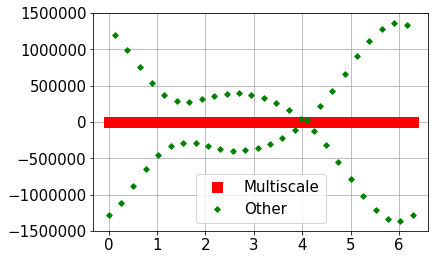

In [28]:
#temporal cell. DELETE LATER
T_max = 1
eps = 1
N = 50
M = 80
delta =1
num=1
method=2
i=70
th,u0,d_T = get_u0(w,F,i,eps,T_max,N,M,delta,num)

t_max = T_max/eps
M2 = int(t_max/d_T + 1)

u1 = np.zeros((N,M))

if method == 1:
    u1 = fd_method(w,wp,F,N,M2,t_max,eps,delta,num)
elif method == 2:
    u1 = fd_method(w,wp,F,N,M2,t_max,eps,delta,num,method="Explicit")
elif method == 3:
    u1 = fft_method(w,wp,F,N,M2,t_max,eps,delta,num)

j = int(i/eps)

plt.plot(th,u0,"rs",ms=10,label="Multiscale")
plt.plot(th,u1[:,j],"gD",ms=4,label="Other")
plt.grid()
plt.legend(loc="best")
plt.show()
